# Overview

In this notebook, I will compare predictions on the 2021 season from my final model against historical odds. Data for the historical odds was gathered from [Sportsbook Reviews Online](https://www.sportsbookreviewsonline.com/scoresoddsarchives/nhl/nhloddsarchives.htm). Per their website: Data is sourced from various online sportsbooks including 5dimes, BetOnline, Bookmaker, Heritage, Pinnacle Sports, Sportsbook.com as well as the Westgate Superbook in Las Vegas.

I will look at 2 simple betting strategies to determine profitability:

1. Bet 100 on every game where either the home or away team winning probability from my model is higher than the implied odds  
2. Bet to win 100 on every game where either the home or away team winning probability from my model is higher than the implied odds

# Data Cleaning and Merging

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
sns.set_style("darkgrid")
sns.set_context("poster")
pd.set_option('display.max_columns', None)

In [2]:
odds = pd.read_excel('data/nhl odds 2021.xlsx')

In [3]:
odds.head()

,Date,Rot,VH,Team,1st,2nd,3rd,Final,Open,Close,PuckLine,Unnamed: 11,OpenOU,Unnamed: 13,CloseOU,Unnamed: 15
0,113,41,V,Pittsburgh,1,1,1,3,-110,-115,1.5,-310,6.0,-110,6.0,105
1,113,42,H,Philadelphia,2,1,3,6,100,-105,-1.5,260,6.0,-110,6.0,-125
2,113,43,V,Montreal,2,1,1,0,132,120,1.5,-220,6.0,-110,6.0,-110
3,113,44,H,Toronto,1,2,1,1,-145,-140,-1.5,195,6.0,-110,6.0,-110
4,113,45,V,Chicago,0,0,1,1,230,210,1.5,-125,6.5,-110,6.5,-110


In [4]:
team_conversion =   { 'Anaheim': 'ANA', 
                      'Arizona' :'ARI', 
                      'Boston': 'BOS', 
                      'Buffalo':'BUF',
                      'Calgary': 'CGY', 
                      'Carolina': 'CAR', 
                      'Chicago': 'CHI', 
                      'Colorado': 'COL',
                     'Columbus': 'CBJ',
                     'Dallas': 'DAL',
                     'Detroit': 'DET',
                     'Edmonton': 'EDM',
                     'Florida': 'FLA',
                     'LosAngeles': 'L.A',
                     'Minnesota': 'MIN',
                     'Montreal': 'MTL',
                     'Nashville': 'NSH',
                     'NewJersey': 'N.J',
                     'NYIslanders': 'NYI',
                     'NYRangers': 'NYR',
                     'Ottawa': 'OTT',
                     'Philadelphia': 'PHI',
                     'Pittsburgh': 'PIT',
                     'SanJose': 'S.J',
                     'St.Louis': 'STL',
                     'TampaBay': 'T.B',
                     'Toronto': 'TOR',
                     'Vancouver': 'VAN',
                      'Vegas':'VGK',
                     'Washington': 'WSH',
                     'Winnipeg': 'WPG'}

In [5]:
#convert date to proper datestring and create team key
odds = odds.replace({'Team': team_conversion})
odds['Month'] = odds['Date'].apply(lambda x: '0'+str(x)[0])
odds['Day'] = odds['Date'].apply(lambda x: str(x)[1:])
odds['Year'] = 2021
odds['Datestring'] = odds[['Year','Month','Day']].astype(str).apply('-'.join, 1)       
odds['Team_Key'] = odds['Team'].astype(str)+'_'+odds['Datestring'].astype(str)
#calculate implied odds
odds['Implied_odds'] = np.where(odds['Close'] < 0, (odds['Close']*-1)/((odds['Close']*-1)+100) , 100/(odds['Close']+100))

In [6]:
odds.head(5)

,Date,Rot,VH,Team,1st,2nd,3rd,Final,Open,Close,PuckLine,Unnamed: 11,OpenOU,Unnamed: 13,CloseOU,Unnamed: 15,Month,Day,Year,Datestring,Team_Key,Implied_odds
0,113,41,V,PIT,1,1,1,3,-110,-115,1.5,-310,6.0,-110,6.0,105,01,13,2021,2021-01-13,PIT_2021-01-13,0.534884
1,113,42,H,PHI,2,1,3,6,100,-105,-1.5,260,6.0,-110,6.0,-125,01,13,2021,2021-01-13,PHI_2021-01-13,0.512195
2,113,43,V,MTL,2,1,1,0,132,120,1.5,-220,6.0,-110,6.0,-110,01,13,2021,2021-01-13,MTL_2021-01-13,0.454545
3,113,44,H,TOR,1,2,1,1,-145,-140,-1.5,195,6.0,-110,6.0,-110,01,13,2021,2021-01-13,TOR_2021-01-13,0.583333
4,113,45,V,CHI,0,0,1,1,230,210,1.5,-125,6.5,-110,6.5,-110,01,13,2021,2021-01-13,CHI_2021-01-13,0.322581


In [7]:
#import file with predictions
predictions = pd.read_csv('data/Predictions_2021b')

In [8]:
#merge my predictions with odd df
df = predictions.merge(odds.loc[:,['Team_Key', 'Implied_odds', 'Close']].add_prefix('home_'), how = 'left', left_on = 'Home_Team_Key', right_on = 'home_Team_Key').drop(columns = 'home_Team_Key')
df = df.merge(odds.loc[:,['Team_Key', 'Implied_odds', 'Close']].add_prefix('away_'), how = 'left', left_on = 'Away_Team_Key', right_on = 'away_Team_Key').drop(columns = 'away_Team_Key')

In [9]:
#odds info only contains info for games up to 5/4. These are the 15 missing games below. 
df.isna().sum()

Unnamed: 0                      0
game_id                         0
date                            0
venue                           0
home_team                       0
away_team                       0
start_time                      0
home_score                      0
away_score                      0
status                          0
Home_Team_Won                   0
Home_Team_Key                   0
Away_Team_Key                   0
home_Game_Number                0
away_Game_Number                0
home_goalie                     0
home_Goalie_FenwickSV%          0
home_Goalie_GSAx/60             0
home_Goalie_HDCSV%              0
away_goalie                     0
away_Goalie_FenwickSV%          0
away_Goalie_GSAx/60             0
away_Goalie_HDCSV%              0
home_last_40_FF%_5v5            0
home_last_40_GF%_5v5            0
home_last_40_xGF%_5v5           0
home_last_40_SH%                0
home_last40_pp_TOI_per_game     0
home_last40_xGF_per_min_pp      0
home_last40_GF

In [10]:
#drop missing games from df
df = df.dropna()

In [11]:
conditions = [df['Home Win Probability'] > df['home_Implied_odds'],
                df['Away Win Probability'] > df['away_Implied_odds']
                 ]
    

choices = ['Home', 
          'Away']

df['Bet'] = np.select(conditions, choices, default = 'No Bet')


In [12]:
df['Favorites'] = np.where(df['home_Implied_odds'] >df['away_Implied_odds'], 'Home', 'Away' )
conditions = [df['Bet'] == 'No Bet',
              df['Bet'] == df['Favorites'],
              df['Bet'] != df['Favorites']
    
    
]
choices = ['No Bet',
           'Favorite',
           'Underdog'
    ]

df['Bet_For'] = np.select(conditions, choices)

In [13]:
#calculate profit for 100$ per game strat
conditions = [((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close'] <0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']<0)),
                ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']>0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [-100 * (100/df['home_Close']), 
           df['home_Close'],
          -100 * (100/df['away_Close']),
          df['away_Close'],
          0]

df['Profit_Strat1'] = np.select(conditions, choices, default = -100)

In [14]:
#calculate profit for bet to win 100$ strat
conditions = [((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close'] <0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close']>0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 0) & (df['home_Close']>0)),
              ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 0) & (df['home_Close']<0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']<0)),
                ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 1) & (df['away_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 1) & (df['away_Close']<0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [100, 
           100,
          (100/df['home_Close'])*-100,
           df['home_Close'],
           100,
           100,
             (100/df['away_Close'])*-100,
          df['away_Close'],
          0]

df['Profit_Strat2'] = np.select(conditions, choices)

In [15]:
#cost of bet to win 100$ strat
conditions = [((df['Bet'] == 'Home') & (df['home_Close']>0)),
              ((df['Bet'] == 'Home') & (df['home_Close']<0)),
              ((df['Bet'] == 'Away') &  (df['away_Close']>0)),
              ((df['Bet'] == 'Away') &  (df['away_Close']<0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [(100/df['home_Close'])*100,
           df['home_Close']*-1,
             (100/df['away_Close'])*100,
          df['away_Close']*-1,
          0]

df['Cost_Strat2'] = np.select(conditions, choices)

In [16]:
#convert date to pandas datetime
df['date'] = pd.to_datetime(df['date'])

In [17]:
#calculate cumulative profit for poth strategies
df['Profit_Strat2_cumsum'] = df['Profit_Strat2'].cumsum()
df['Profit_Strat1_cumsum'] = df['Profit_Strat1'].cumsum()

In [18]:
df['Won_Bet'] = np.where(df['Profit_Strat2'] > 0, 1, 0)

In [19]:
df.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_Game_Number,away_Game_Number,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_GF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,home_last40_GA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_GF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,away_last40_GA_per_min_pk,home_Rating.A.Pre,away_Rating.A.Pre,B2B_Status,Prediction,Away Win Probability,Home Win Probability,home_Implied_odds,home_Close,away_Implied_odds,away_Close,Bet,Favorites,Bet_For,Profit_Strat1,Profit_Strat2,Cost_Strat2,Profit_Strat2_cumsum,Profit_Strat1_cumsum,Won_Bet
0,3626,2020020001,2021-01-13,Wells Fargo Center,PHI,PIT,2021-01-13 22:30:00,6,3,Final,1,PHI_2021-01-13,PIT_2021-01-13,1.0,1.0,Carter Hart,0.936798,-0.097290,0.869565,Tristan Jarry,0.937063,-0.291447,0.834711,51.037671,55.248131,50.833631,10.024139,5.216250,0.104625,0.134196,5.579583,0.088716,0.112016,49.490424,49.414366,49.580182,8.701463,5.068333,0.122230,0.143045,4.693750,0.094008,0.111851,1531.48,1514.01,Neither,1,0.415349,0.584651,0.512195,-105.0,0.534884,-115.0,Home,Away,Underdog,95.238095,100.0,105.0,100.0,95.238095,1
1,3627,2020020003,2021-01-13,Scotiabank Arena,TOR,MTL,2021-01-14 00:00:00,5,4,Final,1,TOR_2021-01-13,MTL_2021-01-13,1.0,1.0,Frederik Andersen,0.936070,-0.305563,0.866051,Carey Price,0.930668,-0.444146,0.862233,50.926333,51.613248,52.907871,9.385230,4.490833,0.102876,0.161440,4.251250,0.095972,0.117612,54.275967,49.447384,54.826724,6.807514,4.443333,0.093567,0.090023,5.106250,0.115594,0.112607,1516.52,1497.57,Neither,1,0.400957,0.599043,0.583333,-140.0,0.454545,120.0,Home,Home,Favorite,71.428571,100.0,140.0,200.0,166.666667,1
2,3628,2020020002,2021-01-13,Amalie Arena,T.B,CHI,2021-01-14 01:00:00,5,1,Final,1,T.B_2021-01-13,CHI_2021-01-13,1.0,1.0,Andrei Vasilevskiy,0.941531,-0.023160,0.876847,Malcolm Subban,0.923432,-0.589420,0.857809,53.085863,60.496256,55.396941,9.975409,5.086667,0.095347,0.098296,5.632500,0.101065,0.106525,49.003131,51.252598,47.514358,9.212376,5.646667,0.107010,0.084120,4.739583,0.103226,0.089670,1584.31,1492.13,Neither,1,0.301636,0.698364,0.714286,-250.0,0.322581,210.0,No Bet,Home,No Bet,0.000000,0.0,0.0,200.0,166.666667,0
3,3629,2020020004,2021-01-13,Rogers Place,EDM,VAN,2021-01-14 03:00:00,3,5,Final,0,EDM_2021-01-13,VAN_2021-01-13,1.0,1.0,Mikko Koskinen,0.938316,-0.009204,0.867299,Braden Holtby,0.927771,-0.408527,0.852194,48.540721,47.474864,48.384948,8.348491,4.868750,0.111322,0.154044,4.358333,0.114551,0.103250,47.274508,48.647099,46.039131,8.973817,5.262917,0.098805,0.128256,5.131250,0.110110,0.116931,1490.93,1510.30,Neither,1,0.406995,0.593005,0.600000,-150.0,0.434783,130.0,No Bet,Home,No Bet,0.000000,0.0,0.0,200.0,166.666667,0
4,3630,2020020005,2021-01-13,Ball Arena,COL,STL,2021-01-14 03:30:00,1,4,Final,0,COL_2021-01-13,STL_2021-01-13,1.0,1.0,Philipp Grubauer,0.938738,-0.054610,0.852300,Jordan Binnington,0.936047,-0.058439,0.891566,54.173584,55.777256,54.433969,8.037510,5.254167,0.107819,0.118953,4.904583,0.115045,0.091751,53.469034,58.414704,53.596844,8.848351,4.181250,0.128311,0.161435,4.751667,0.124851,0.142055,1549.43,1526.11,Neither,1,0.459578,0.540422,0.591837,-145.0,0.444444,125.0,Away,Home,Underdog,125.000000,100.0,80.0,300.0,291.666667,1


---

# Evaluation
Let's check the log loss from the implied odds. My model's log loss on the 2021 season was 0.655534. So the book implied odds are still performing slightly better with a log loss of 0.6529

In [21]:
from sklearn.metrics import log_loss, accuracy_score

io_list = []

for index, row in df.iterrows():
    io_list.append([row['away_Implied_odds'], row['home_Implied_odds']])
    

log_loss(df['Home_Team_Won'], io_list)

0.6529358923310422

How many bets would be for home vs away vs no bet? My model is definitley favoring the home team. From the EDA notebook, The home team had won 56.0% in the 17-18 season, 53.7% in 18-19, 53.1% in 19-20 and only 52.7% in 20-21 season. THe 20-21 season having no fans may be affecting this outcome for the home team and may have hurt the model slightly for the 20-21 season.

In [22]:
df['Bet'].value_counts()

Home      476
Away      187
No Bet    142
Name: Bet, dtype: int64

In [23]:
df['Bet'].value_counts(normalize = True)

Home      0.591304
Away      0.232298
No Bet    0.176398
Name: Bet, dtype: float64

How many bets were for the favorite vs the underdrog? Interestingly the model liked underdogs more often. 

In [24]:
df['Bet_For'].value_counts(normalize = 'True')

Underdog    0.472050
Favorite    0.351553
No Bet      0.176398
Name: Bet_For, dtype: float64

The strategy of betting to win 100$ resulted in a per bet ROI of 2.04%

In [26]:
#ROI per bet
df['Profit_Strat2'].sum() / df['Cost_Strat2'].sum()

0.02038826661822943

Total profit for this strategy would have been $1,473.69

In [27]:
#total profit
df['Profit_Strat2'].sum()

1473.6935352451542

The strategy was profitable initially and dipped down into the red for short period in mid March. You would have only needed an initial bankroll of 325 to implement this and then would have needed to re-up 244 later for total out of pocket costs of 569

In [28]:
#initial bankroll needed 
df[df['date'] == '2021-01-13']['Cost_Strat2'].sum()

325.0

In [41]:
df[df['Profit_Strat2_cumsum'] < 0]

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_Game_Number,away_Game_Number,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_GF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,home_last40_GA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_GF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,away_last40_GA_per_min_pk,home_Rating.A.Pre,away_Rating.A.Pre,B2B_Status,Prediction,Away Win Probability,Home Win Probability,home_Implied_odds,home_Close,away_Implied_odds,away_Close,Bet,Favorites,Bet_For,Profit_Strat1,Profit_Strat2,Cost_Strat2,Profit_Strat2_cumsum,Profit_Strat1_cumsum,Won_Bet
368,3994,2020020393,2021-03-07,PPG Paints Arena,PIT,NYR,2021-03-08 00:30:00,5,1,Final,1,PIT_2021-03-07,NYR_2021-03-07,51.0,49.0,Casey DeSmith,0.933021,-0.140690,0.859189,Keith Kinkaid,0.917710,-1.113305,0.826972,50.540259,47.917687,47.961442,8.580641,5.290833,0.119027,0.113404,5.027083,0.102047,0.139246,48.440275,53.570045,49.965536,8.656284,5.690000,0.110545,0.109842,5.448333,0.125635,0.100948,1512.55,1496.34,Both,1,0.431228,0.568772,0.591837,-145.0,0.431034,132.0,Away,Home,Underdog,-100.000000,-75.757576,75.757576,-19.450087,-1038.198862,0
369,3995,2020020250,2021-03-07,American Airlines Center,DAL,NSH,2021-03-08 01:00:00,3,4,Final,0,DAL_2021-03-07,NSH_2021-03-07,16.0,17.0,Jake Oettinger,0.935086,-0.255694,0.862060,Pekka Rinne,0.921053,-0.819560,0.835476,49.880112,49.938570,52.248263,6.969115,5.700833,0.101301,0.144716,5.327917,0.120075,0.140768,51.026809,43.714875,48.941666,6.320651,5.576667,0.111447,0.107591,5.351667,0.108751,0.154158,1517.95,1475.99,Both,1,0.409117,0.590883,0.600000,-150.0,0.425532,135.0,No Bet,Home,No Bet,0.000000,0.000000,0.000000,-19.450087,-1038.198862,0
370,3996,2020020395,2021-03-07,Scotiabank Saddledome,CGY,OTT,2021-03-08 02:30:00,3,4,Final,0,CGY_2021-03-07,OTT_2021-03-07,33.0,40.0,Jacob Markstrom,0.937607,-0.117806,0.876147,Matt Murray,0.917826,-0.897528,0.831169,50.138135,52.448172,52.522418,9.109935,5.175833,0.102013,0.140074,5.125000,0.108195,0.107317,49.750455,41.918774,48.665630,7.597275,5.430000,0.105893,0.087477,4.887083,0.116941,0.179043,1498.71,1421.18,Home_only,1,0.371348,0.628652,0.636364,-175.0,0.389105,157.0,No Bet,Home,No Bet,0.000000,0.000000,0.000000,-19.450087,-1038.198862,0
371,3997,2020020398,2021-03-08,Xcel Energy Center,MIN,VGK,2021-03-09 01:00:00,2,0,Final,1,MIN_2021-03-08,VGK_2021-03-08,50.0,51.0,Kaapo Kahkonen,0.940781,-0.332087,0.869565,Marc-Andre Fleury,0.933873,-0.237357,0.846361,51.537717,58.327481,55.517912,10.180797,5.923750,0.092129,0.080186,5.927917,0.088944,0.084347,55.910008,58.265363,56.419420,9.088790,4.960417,0.117379,0.115918,4.351250,0.102442,0.132146,1514.32,1565.75,Neither,0,0.503350,0.496650,0.523810,-110.0,0.500000,100.0,Away,Home,Underdog,-100.000000,-100.000000,100.000000,-119.450087,-1138.198862,0
372,3998,2020020326,2021-03-08,SAP Center at San Jose,S.J,STL,2021-03-09 02:00:00,3,2,Final,1,S.J_2021-03-08,STL_2021-03-08,18.0,23.0,Devan Dubnyk,0.918974,-1.102545,0.800000,Ville Husso,0.935086,-0.255694,0.862060,49.498608,43.207074,50.495442,7.524555,4.769167,0.108143,0.115324,5.906667,0.100141,0.114278,50.992899,55.855080,51.731223,8.979396,4.401250,0.114229,0.119284,5.149167,0.120117,0.165075,1452.63,1528.30,Neither,0,0.555734,0.444266,0.396825,152.0,0.625468,-167.0,Home,Away,Underdog,152.000000,100.000000,65.789474,-19.450087,-986.198862,1
373,3999,2020020396,2021-03-08,Rogers Place,EDM,OTT,2021-03-09 02:00:00,3,2,Final,1,EDM_2021-03-08,OTT_2021-03-08,37.0,43.0,Mikko Koskinen,0.931777,-0.300626,0.850230

I would have won only 49.6% of bets, but since the marjority of bets were for the underdog, the lower costs benefited profitability. 

In [29]:
df[df['Bet'] != 'No Bet']['Won_Bet'].value_counts(normalize = True)

0    0.503771
1    0.496229
Name: Won_Bet, dtype: float64

Strategy 1, bet 100$ every bettable game was slightly profitable.

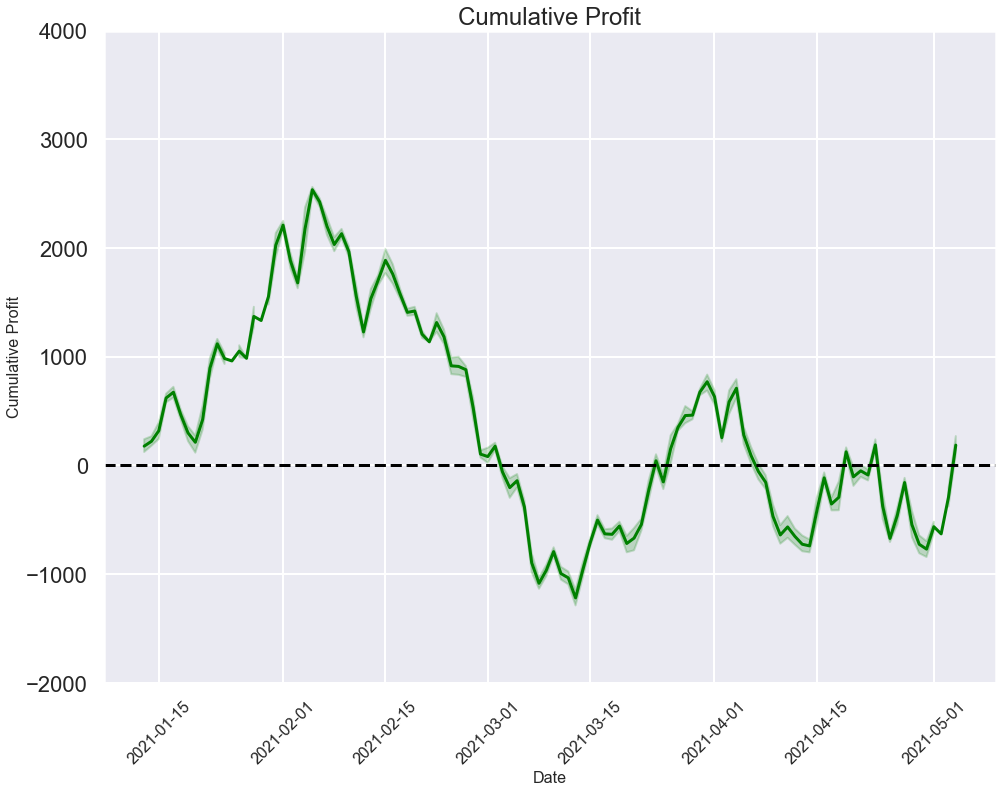

In [48]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = df['date'], y = df['Profit_Strat1_cumsum'], color = 'green')
ax.set_title('Cumulative Profit', fontsize = 24)
ax.set_ylabel('Cumulative Profit', fontsize =16, )
ax.set_xlabel('Date', fontsize =16)
plt.xticks(rotation=45, fontsize = 16)
ax.axhline(0, linestyle = 'dashed', color = 'black')
ax.set_ylim(-2000,4000)



plt.show()

Strategy 2, bet to win 100$ on every bettable game, was profitbale

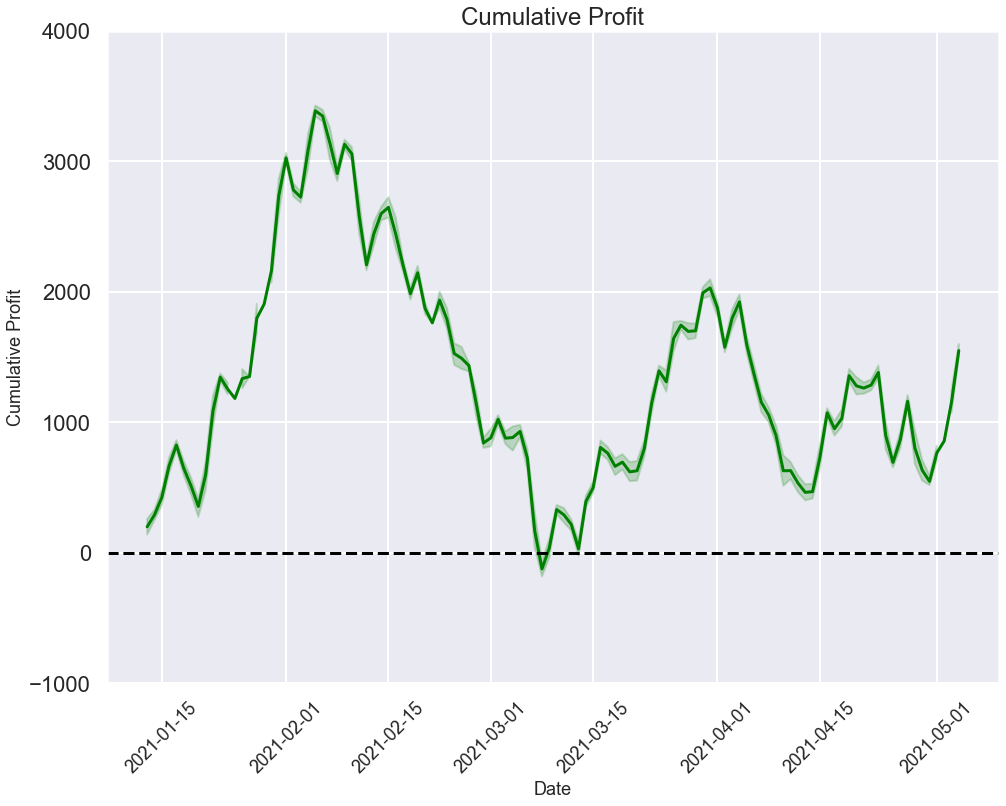

In [49]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = df['date'], y = df['Profit_Strat2_cumsum'], color = 'green')
ax.set_title('Cumulative Profit', fontsize = 24)
ax.set_ylabel('Cumulative Profit', fontsize =18, )
ax.set_xlabel('Date', fontsize =18)
plt.xticks(rotation=45, fontsize = 18)
ax.axhline(0, linestyle = 'dashed', color = 'black')
ax.set_ylim(-1000,4000)



plt.show()

In [36]:
strat2 = pd.DataFrame(df.groupby('date').agg({'Profit_Strat2': 'sum'})).reset_index()

strat2['Cumulative Profit'] = strat2['Profit_Strat2'].cumsum()

strat2['date'] = pd.to_datetime(strat2['date'])

In [37]:
strat2.head()

,date,Profit_Strat2,Cumulative Profit
0,2021-01-13,300.000000,300.000000
1,2021-01-14,-79.500000,220.500000
2,2021-01-15,220.000000,440.500000
3,2021-01-16,423.664122,864.164122
4,2021-01-17,-75.757576,788.406546


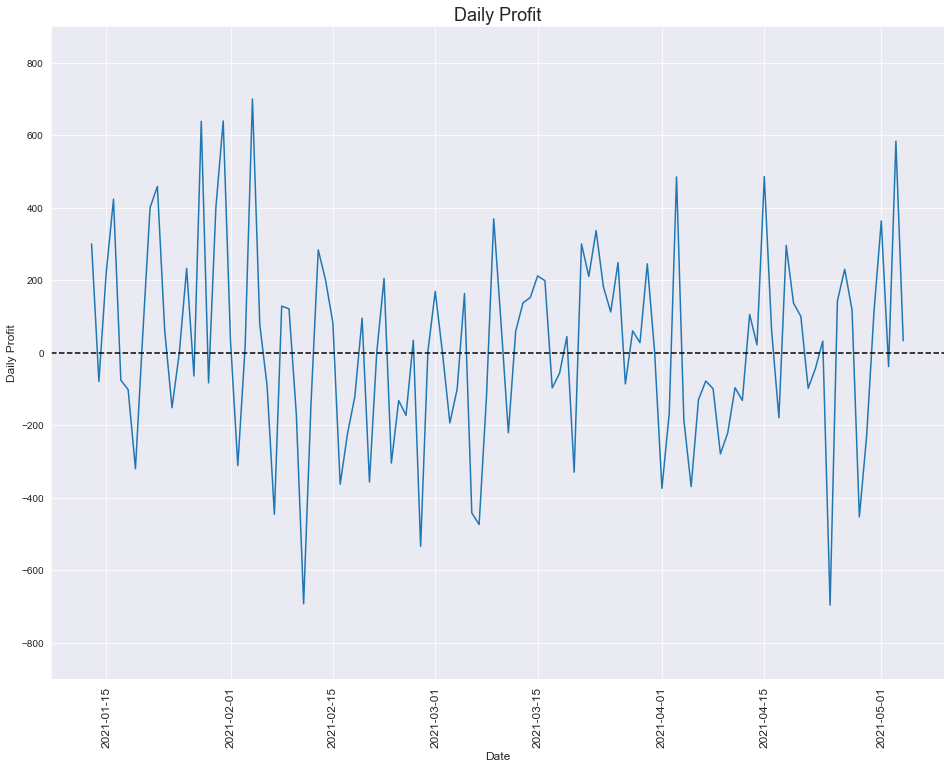

In [38]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = strat2['date'], y = strat2['Profit_Strat2'], palette = 'Blues')
ax.set_title('Daily Profit', fontsize = 18)
ax.set_ylabel('Daily Profit', fontsize =12, )
ax.set_xlabel('Date', fontsize =12)
plt.xticks(rotation='vertical', fontsize = 12)
ax.axhline(0, color = 'black', linestyle = 'dashed')
ax.set_ylim(-900,900)
plt.show()